# Visualization

Loading data: outputs/final_results/rooftop_solar_potential_optimized.geojson
Successfully corrected 7 large building zoning labels.
Data preparation complete. Total 4608 buildings. Starting plotting...

Map 1 Vmax: 233540.93 kWh/yr
   Generating plot: Rooftop Solar Potential ...
      Saved: outputs/Fig\Fig_Rooftop_Solar_Potential.pdf


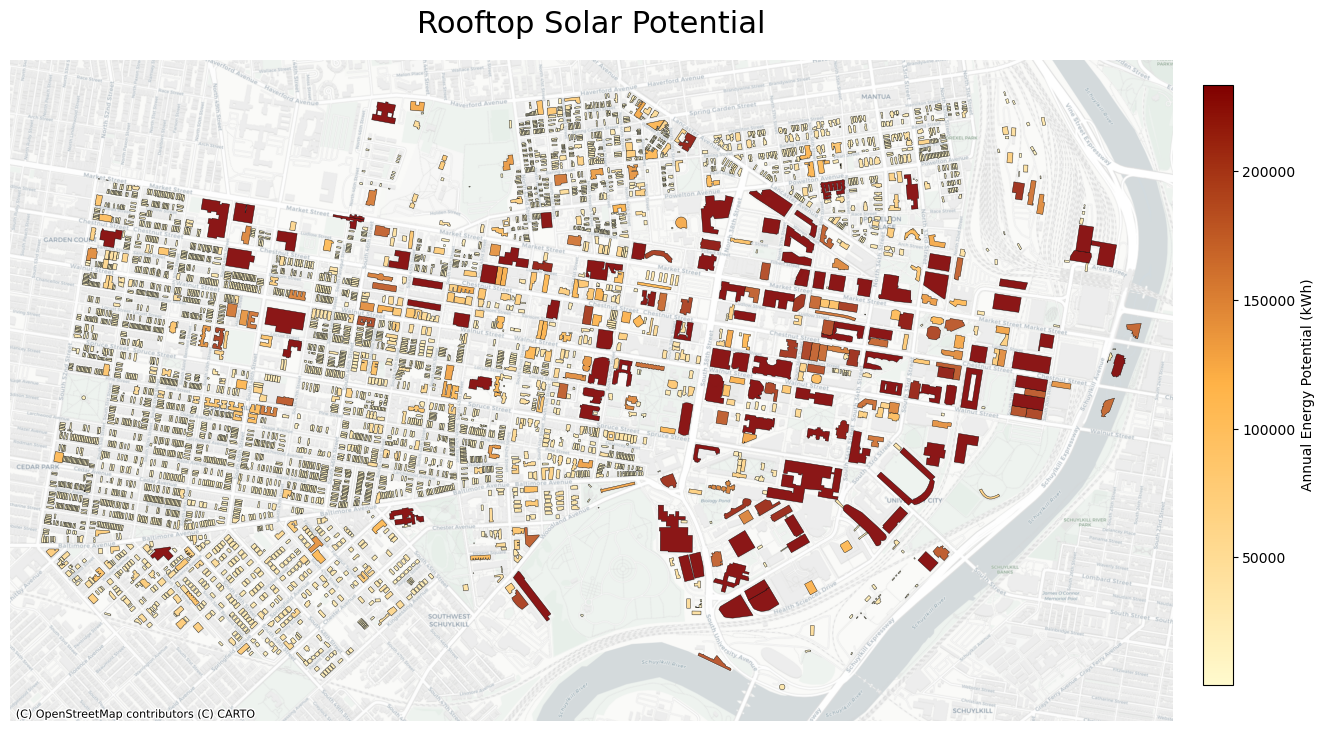


Map 2 Vmax: 17.43 years
   Generating plot: Economic Payback Period ...
      Saved: outputs/Fig\Fig_Economic_Payback_Period.pdf


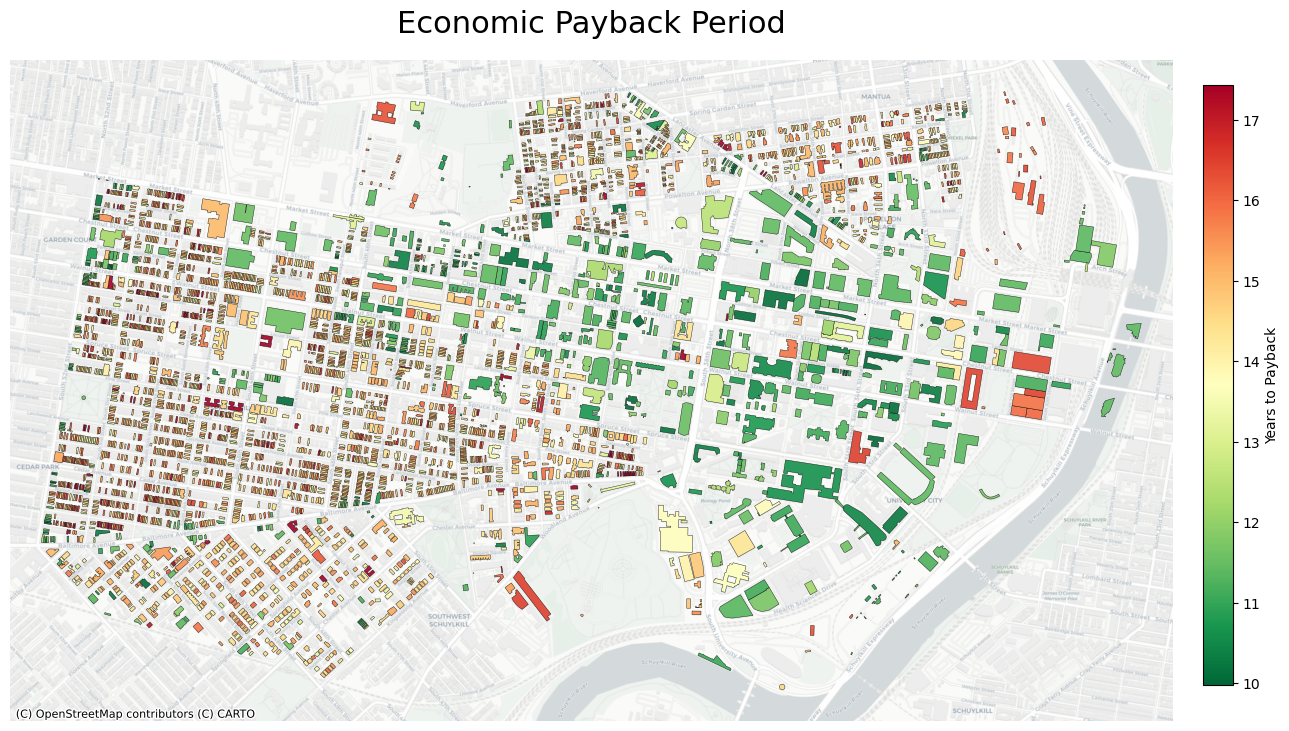

   Generating plot: Shading Analysis ...
      Saved: outputs/Fig\Fig_Shading_Analysis.pdf


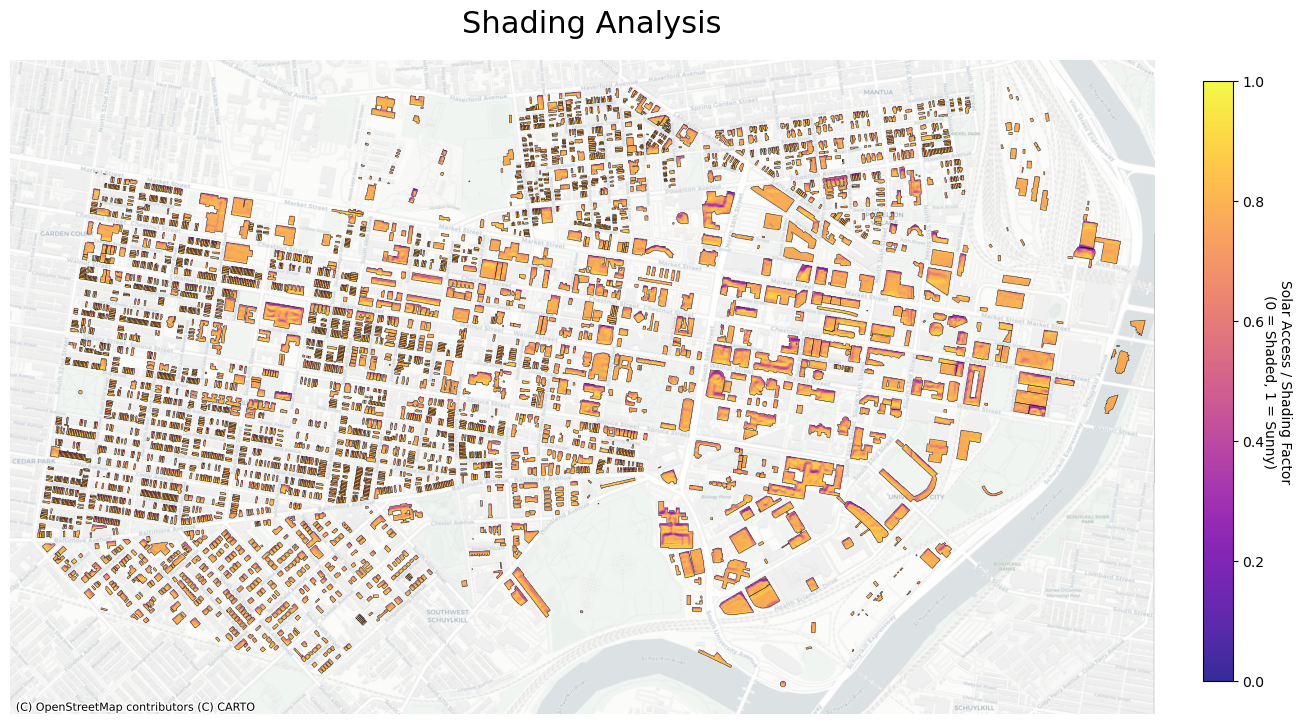


All processing complete!


In [5]:
import os
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx
import rasterio
from rasterio.plot import show
from rasterio.mask import mask 
from IPython.display import display
%matplotlib inline


# Section 1: Global Configuration

class Config:
    # Path Configuration
    GEOJSON_PATH = 'outputs/final_results/rooftop_solar_potential_optimized.geojson'
    SHADE_TIF_PATH = 'outputs/final_results/shading_factor.tif'
    OUTPUT_MAP_DIR = 'outputs/Fig'
    
    # Plotting Layout
    FIG_SIZE = (15, 12)
    LEGEND_LOC = [0.92, 0.25, 0.02, 0.5] # [Left, Bottom, Width, Height]
    MAP_PADDING = 150 # meters
    
    # Business Logic Thresholds
    AREA_THRESHOLD_INSTITUTIONAL = 3000 
    
    # Custom Colormap
    MAROON_CMAP = colors.LinearSegmentedColormap.from_list(
        "custom_maroon", ['#FFFACD', '#FFB347', '#800000']
    )

    @staticmethod
    def check_paths():
        os.makedirs(Config.OUTPUT_MAP_DIR, exist_ok=True)
        if not os.path.exists(Config.GEOJSON_PATH):
            raise FileNotFoundError(f"Error: File not found: {Config.GEOJSON_PATH}")


# Section 2: Data Processing Utilities

def load_and_clean_data():
    """Load GeoJSON and perform specific cleaning logic (e.g., zoning correction)."""
    print(f"Loading data: {Config.GEOJSON_PATH}")
    gdf = gpd.read_file(Config.GEOJSON_PATH)

    # 1. Fill/Cast numeric columns
    cols_to_fix = ['potential_kwh', 'payback_years', 'yearly_savings', 'area_m2']
    for col in cols_to_fix:
        if col in gdf.columns:
            gdf[col] = gdf[col].fillna(0).astype(float)

    # 2. Correct Zoning Classification (Business Logic)
    gdf['zoning_type_clean'] = gdf['zoning_type']
    
    is_residential = gdf['zoning_type'].astype(str).str.contains('Resid', case=False, na=False)
    is_oversized = gdf['area_m2'] > Config.AREA_THRESHOLD_INSTITUTIONAL
    outlier_mask = is_residential & is_oversized

    if outlier_mask.any():
        gdf.loc[outlier_mask, 'zoning_type_clean'] = 'Institutional/Hospital'
        print(f"Successfully corrected {outlier_mask.sum()} large building zoning labels.")
    
    # 3. Standardize CRS (Web Mercator for plotting)
    gdf_web = gdf.to_crs(epsg=3857) if gdf.crs.to_string() != 'EPSG:3857' else gdf
    
    return gdf_web

def calculate_bounds(gdf, padding=150):
    """Calculate unified map extent (Web Mercator)."""
    minx, miny, maxx, maxy = gdf.total_bounds
    return (minx - padding, maxx + padding, miny - padding, maxy + padding)

def get_robust_vmax(series, percentile=98):
    """Calculate a robust upper limit (vmax) by excluding outliers."""
    valid_data = series.replace([np.inf, -np.inf], np.nan).dropna()
    if valid_data.empty:
        return 0
    vmax = np.percentile(valid_data, percentile)
    # Fallback if percentile calculation yields an anomalous result
    return vmax if vmax > valid_data.min() else valid_data.max()


# Section 3: Visualization Engine

def plot_vector_map(gdf, column, title, cmap, legend_label, output_name, limits, vmax=None):
    """Generic vector plot function (Map 1 & 2)."""
    print(f"   Generating plot: {title} ...")
    
    fig, ax = plt.subplots(figsize=Config.FIG_SIZE)
    cax = fig.add_axes(Config.LEGEND_LOC) 

    plot_kwargs = {
        'column': column,
        'ax': ax,
        'cax': cax,
        'legend': True,
        'legend_kwds': {'label': legend_label, 'orientation': "vertical"},
        'cmap': cmap,
        'alpha': 0.9,       
        'edgecolor': 'black',  
        'linewidth': 0.3
    }
    if vmax:  
        plot_kwargs['vmax'] = vmax

    gdf.plot(**plot_kwargs)
    
    # Set unified map extent
    ax.set_xlim(limits[0], limits[1])
    ax.set_ylim(limits[2], limits[3])
    
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=16)
    except Exception as e:
        print(f"      Warning: Basemap failed to load: {e}")

    if title:
        ax.set_title(title, fontsize=22, pad=20)
    ax.set_axis_off()
    
    save_path = os.path.join(Config.OUTPUT_MAP_DIR, output_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"      Saved: {save_path}")
    plt.show()
    plt.close(fig)

def plot_raster_map(gdf, tif_path, title, limits):
    """Shading analysis raster plot (Map 3)."""
    print(f"   Generating plot: {title} ...")
    
    if not os.path.exists(tif_path):
        print("      Error: TIF file missing, skipping shading map.")
        return

    save_path = os.path.join(Config.OUTPUT_MAP_DIR, 'Fig_Shading_Analysis.pdf')
    
    with rasterio.open(tif_path) as src:
        # Ensure vector CRS matches raster CRS for masking
        gdf_utm = gdf.to_crs(src.crs)
        try:
            out_image, out_transform = mask(src, gdf_utm.geometry, crop=True, nodata=np.nan)
            shading_data = out_image[0]
        except ValueError:
            print("      Warning: Masking failed, skipping.")
            return

        fig, ax = plt.subplots(figsize=Config.FIG_SIZE)
        cax = fig.add_axes(Config.LEGEND_LOC)

        # Plot raster data
        im = ax.imshow(
            shading_data, 
            cmap='plasma', 
            vmin=0, vmax=1, 
            extent=rasterio.plot.plotting_extent(out_image[0], out_transform),
            alpha=0.85, 
            zorder=2    
        )
        
        # Plot building outlines over raster
        gdf_utm.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.3, alpha=0.8, zorder=3)

        # Add basemap
        try:
            ctx.add_basemap(ax, crs=src.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=16, alpha=0.8)
        except Exception: 
            pass

        # Set unified map extent (based on masked data bounds + padding)
        utm_minx, utm_miny, utm_maxx, utm_maxy = gdf_utm.total_bounds
        pad = 100 
        ax.set_xlim(utm_minx - pad, utm_maxx + pad)
        ax.set_ylim(utm_miny - pad, utm_maxy + pad)

        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Solar Access / Shading Factor\n(0 = Shaded, 1 = Sunny)', rotation=270, labelpad=20)

        ax.set_title(title, fontsize=22, pad=20)
        ax.set_axis_off()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"      Saved: {save_path}")
        plt.show()
        plt.close(fig)


# Section 4: Main Execution Flow

def main():
    try:
        # 0. Check Environment
        Config.check_paths()
    except FileNotFoundError as e:
        print(e)
        return
        
    # 1. Load Data
    gdf_web = load_and_clean_data()
    
    # 2. Calculate Global Unified Extents (Web Mercator)
    web_limits = calculate_bounds(gdf_web, padding=Config.MAP_PADDING)
    print(f"Data preparation complete. Total {len(gdf_web)} buildings. Starting plotting...")

    # 3. Plot Map 1: Rooftop Solar Potential
    pot_col = 'potential_kwh'
    pot_vmax = get_robust_vmax(gdf_web[pot_col], percentile=98)
    print(f"\nMap 1 Vmax: {pot_vmax:.2f} kWh/yr")
    
    plot_vector_map(
        gdf_web, 
        column=pot_col, 
        title='Rooftop Solar Potential',
        cmap=Config.MAROON_CMAP,
        legend_label='Annual Energy Potential (kWh)',
        output_name='Fig_Rooftop_Solar_Potential.pdf',
        limits=web_limits,
        vmax=pot_vmax
    )

    # 4. Plot Map 2: Payback Period
    pay_col = 'payback_years'
    pay_vmax = get_robust_vmax(gdf_web[pay_col], percentile=98)
    print(f"\nMap 2 Vmax: {pay_vmax:.2f} years")

    plot_vector_map(
        gdf_web,
        column=pay_col,
        title='Economic Payback Period',
        cmap='RdYlGn_r',
        legend_label="Years to Payback",
        output_name='Fig_Economic_Payback_Period.pdf',
        limits=web_limits,
        vmax=pay_vmax
    )

    # 5. Plot Map 3: Shading Analysis
    plot_raster_map(
        gdf_web, 
        Config.SHADE_TIF_PATH, 
        title='Shading Analysis', 
        limits=web_limits
    )
    
    print("\nAll processing complete!")

if __name__ == "__main__":
    main()